Prezentacja wyników klasyfikacji liter
Wprowadzenie
W tej prezentacji zajmiemy się klasyfikacją liter alfabetu. Skorzystamy z wytrenowanego modelu i zbioru danych testowych do przewidywania liter na obrazkach.

1. Importowanie bibliotek
Najpierw musimy zaimportować niezbędne biblioteki do analizy danych i uczenia maszynowego. Oto niezbędne biblioteki:

In [22]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from model import Net
import torch.nn as nn
import torch.nn.functional as F
import re
import random

2. Przygotowanie danych do trenowania
Wcześniej przeprowadziliśmy przygotowanie danych do trenowania i wczytaliśmy je z plików:

In [2]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')
X_test = np.load('X_test.npy')

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)

3. Wczytywanie danych testowych
Przygotowaliśmy dane testowe, które zostaną użyte do klasyfikacji liter. Wczytujemy je z pliku X_test.npy:


In [3]:
X_test = np.load('X_test.npy')
X_test = torch.tensor(X_test, dtype=torch.float32)
test_dataset = TensorDataset(X_test)

4. Wczytanie wytrenowanego modelu
Model, który zostanie użyty do klasyfikacji liter, jest już wytrenowany i zapisany w pliku "model.pt". Wczytujemy go:

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(784, 26).to(device)
model.load_state_dict(torch.load("model.pt"))
model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=26, bias=True)
)

5. Architektura modelu
Oto jak wygląda architektura modelu sieci neuronowej, która została użyta do klasyfikacji liter:

In [9]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

6. Przygotowanie danych do trenowania
Przygotowaliśmy dane treningowe i walidacyjne wcześniej. Oto jak je przygotowaliśmy:

In [16]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 50

7. Funkcje trenowania modelu
Oto funkcje train i validate, które zostały użyte do treningu modelu:


In [12]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        data = data.view(data.size(0), -1)

        optimizer.zero_grad()
        output = model(data)

        target = target.float()

        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(data), len(train_loader.dataset),
                          100. * batch_idx / len(train_loader), loss.item()))

def validate():
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target_onehot in val_loader:
            data = data.to(device)
            target = torch.argmax(target_onehot, dim=1).to(device)

            data = data.view(data.size(0), -1)

            output = model(data)
            val_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(val_loss, correct, len(val_loader.dataset),
                  100. * correct / len(val_loader.dataset)))

8. Przygotowanie danych pod wykresy

In [29]:
train_losses = []
val_losses = []
val_accuracies = []

# Otwarcie pliku z wynikami trenowania
with open('50_epochs_result_training.txt', 'r') as file:
    lines = file.readlines()

# Wyrażenia regularne do wyodrębnienia informacji o błędach i dokładności
train_loss_pattern = re.compile(r'Train Epoch: \d+.*Loss: (\d+\.\d+)')
val_loss_pattern = re.compile(r'Validation set: Average loss: (\d+\.\d+)')
val_accuracy_pattern = re.compile(r'Validation set: Average loss: \d+\.\d+, Accuracy: (\d+)/(\d+)')

# Przechodzenie przez linie w pliku i wyodrębnianie danych
for line in lines:
    train_loss_match = train_loss_pattern.search(line)
    val_loss_match = val_loss_pattern.search(line)
    val_accuracy_match = val_accuracy_pattern.search(line)

    if train_loss_match:
        train_loss = float(train_loss_match.group(1))
        train_losses.append(train_loss)
    if val_loss_match:
        val_loss = float(val_loss_match.group(1))
        val_losses.append(val_loss)
    if val_accuracy_match:
        val_accuracy = int(val_accuracy_match.group(1))
        val_total = int(val_accuracy_match.group(2))
        val_accuracy_percent = (val_accuracy / val_total) * 100  # Konwersja na procenty
        val_accuracies.append(val_accuracy_percent)
 

9. Wykresy wyników treningu
Teraz przyjrzyjmy się wykresom przedstawiającym wyniki treningu modelu. Oto wykres dokładności i straty na zbiorze walidacyjnym w trakcie treningu:

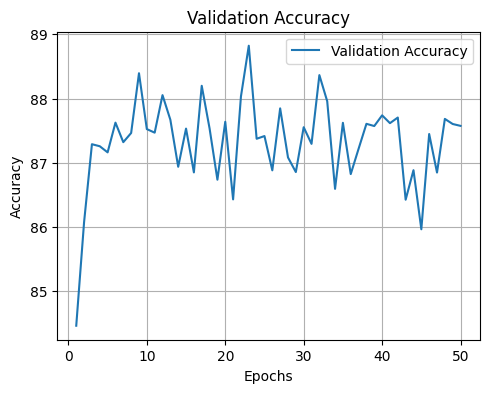

In [32]:
# Tworzenie listy epok
epochs = list(range(1, 51))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

10. Klasyfikacja liter
Teraz przystępujemy do klasyfikacji liter na zbiorze testowym. Wykorzystujemy wczytany model i zapisujemy wyniki:

In [21]:
# Tworzenie mapowania między klasami a literami
class_to_letter = {i: chr(65 + i) for i in range(26)}

# Inicjalizacja listy wyników
results = []

# Przetestowanie modelu na zbiorze testowym i zapis wyników
for i in range(len(X_test)):
    data = X_test[i].view(1, -1).to(device)
    output = model(data)

    predicted_class = output.argmax().item()
    predicted_letter = class_to_letter[predicted_class]

    # Zapis wyniku (numer indeksu i przewidywaną literę jako int)
    results.append([i, predicted_class])

# Zapis wyniki do pliku CSV
results_df = pd.DataFrame(results, columns=["index", "class"])
results_df.to_csv("submission.csv", index=False)

print("Wyniki zostały zapisane do submission.csv.")

Wyniki zostały zapisane do submission.csv.


11. Wizualizacja wyników
Ostatnią częścią prezentacji jest wizualizacja wyników. Możemy wybrać losowe obrazy ze zbioru testowego, skorzystać z wytrenowanego modelu do ich klasyfikacji i wyświetlić obrazy wraz z przewidywanymi literami. Oto jak to zrobimy:

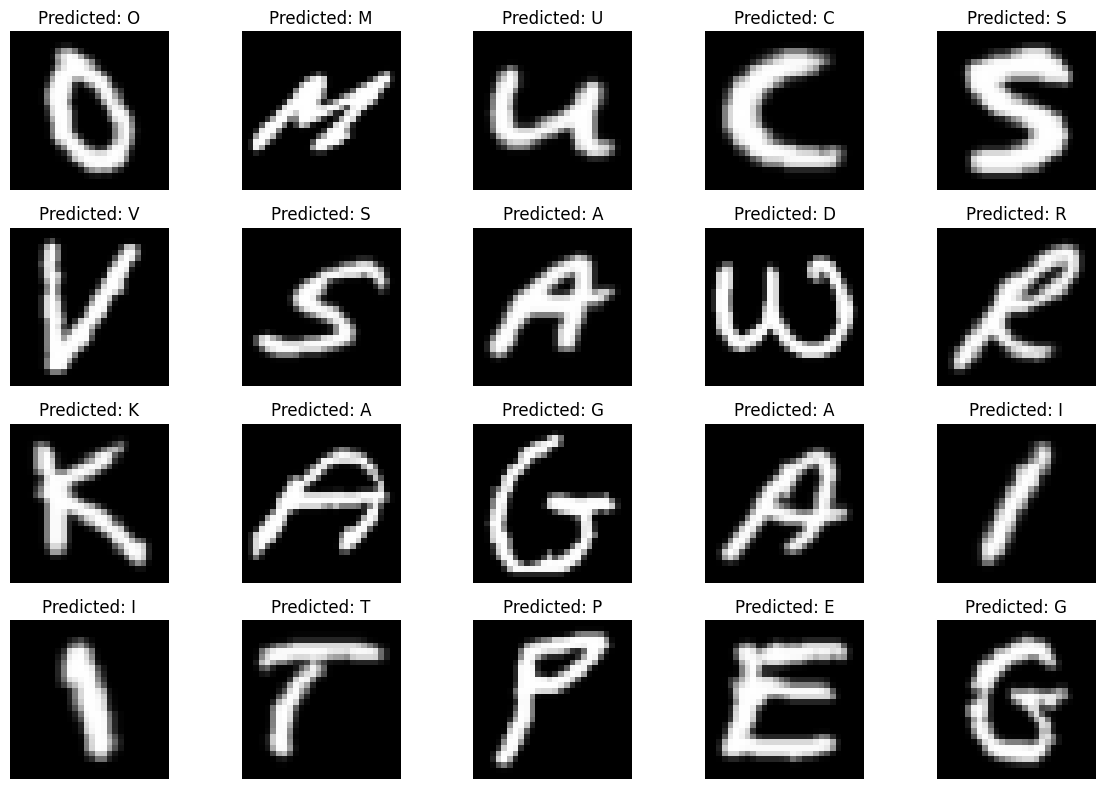

In [27]:
# Inicjalizacja wykresu
fig, axs = plt.subplots(4, 5, figsize=(12, 8))
class_to_letter = {i: chr(65 + i) for i in range(26)}

# Wyświetlenie przykładowych obrazków i przewidywanych liter
for i in range(20):
    example_idx = random.randint(0, len(X_test) - 1)
    data = X_test[example_idx].view(1, -1).to(device)
    output = model(data)

    predicted_class = output.argmax().item()
    predicted_letter = class_to_letter[predicted_class]

    row, col = divmod(i, 5)
    axs[row, col].imshow(data.view(28, 28).cpu().numpy(), cmap='gray')
    axs[row, col].set_title(f'Predicted: {predicted_letter}')
    axs[row, col].axis('off')  # Wyłącz wyświetlanie osi

plt.tight_layout()  # Popraw wygląd wykresu
plt.show()